### In this module we will run YOLO on our test set and analyze its outputs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from ultralytics import YOLO
import torch
os.sys.path.append('../utils') #To load master_configuration.yaml
from readYAML import read_config_file #To load in master configuration

### Once again lets set up our configuration

In [2]:
def load_configuration(file_path):
    
    #Read yoloConf field of yaml file
    conf = read_config_file(file_path)['yoloConf']
    
    #Check the Ultralytics fields in master_configuration.yaml based on if we're using noise and linear or log scale images
    if conf['noise'] == True:
        if conf['log_scale'] == True:
            Ultconf = read_config_file(file_path)['log_scale_noise']
        else:
            Ultconf = read_config_file(file_path)['linear_scale_noise']
    else:
        if conf['log_scale'] == True:
            Ultconf = read_config_file(file_path)['log_scale']
        else:
            Ultconf = read_config_file(file_path)['linear_scale']
    #Append the correct ultralytics training information to our yolo configuration
    conf.update(Ultconf)
    return conf

In [3]:
conf = load_configuration('../master_configuration.yaml')

In [4]:
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

### Load test set

In [5]:
'''Calling our testset dataframe df'''
df = pd.read_feather("../data/test%s.feather"%(conf['suffix']))

# Now let's evaluate YOLO on the test images

After training yolo it will create a directory called *runs/*. You'll need to navigate through runs and find the
desired model you trained. In the example below *train13/* is the directory that we're using. The *weights/* subdirectory contains two files, one called 'best' and the other called 'last'. 'best' is the saved weights file during the best performing epoch of training. It's typically best to use this file.

In [6]:
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

In [7]:
# MAY NEED TO CHANGE THE WEIGHTS PATH

from PIL import Image

#Directory of the test PNG images we created is determined by conf['suffix']

testpath = '../datasets/test%s/images/'%(conf['suffix'])

#Create a sorted list of PIL images to pass into YOLO
images = [Image.open(testpath+val) for val in sorted(os.listdir(testpath))]
print('Performing YOLO inference\n')

#Load trained YOLO model weights. Where we look will depend on if the model is pretrained or not
if conf['use_pretrained'] == True:
    subpath = os.path.split(conf['project'])[1] #extracts e.g. "raw_linear", "noise_log", etc
    weights_file = '../pretrained/%s/train/weights/best.pt'%(subpath)
else:
    weights_file = conf['project']+'/train/weights/best.pt'

model = YOLO(weights_file)

#Perform YOLO inference on all images
results = model.predict(images,batch = len(images),verbose = False, workers = 1,imgsz=512,rect=True)

Performing YOLO inference



### Let's take a closer look at the results file before analyzing

In [8]:
#The length of the results list should always be the same as the test dataframe
print(len(results),len(df))

#Looking through the results list, each entry has a boxes and keypoints object
results

112 112


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: ultralytics.engine.results.Keypoints object
 masks: None
 names: {0: 'ER'}
 obb: None
 orig_img: array([[[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [127,   0,   0],
         [127,   0,   0],
         [127,   0,   0]],
 
        [[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [127,   0,   0],
         [127,   0,   0],
         [127,   0,   0]],
 
        [[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [127,   0,   0],
         [127,   0,   0],
         [127,   0,   0]],
 
        ...,
 
        [[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [127,   0,   0],
         [127,   0,   0],
         [127,   0,   0]],
 
        [[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0

In [9]:
#Now lets look at boxes and keypoints for the first image
print(results[0].boxes)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.8479])
data: tensor([[254.0000, 145.0000, 293.0000, 168.0000,   0.8479,   0.0000]])
id: None
is_track: False
orig_shape: (288, 512)
shape: torch.Size([1, 6])
xywh: tensor([[273.5000, 156.5000,  39.0000,  23.0000]])
xywhn: tensor([[0.5342, 0.5434, 0.0762, 0.0799]])
xyxy: tensor([[254., 145., 293., 168.]])
xyxyn: tensor([[0.4961, 0.5035, 0.5723, 0.5833]])


In [10]:
#The above shows several options for boxes. The xyxyn format gives [xmin,ymin,xmax,ymax] of the bounding box
#normalized to 1. This is what we should use so we can upscale the box to the 2048 x 1152 image

results[0].boxes.xyxyn.cpu().numpy()

array([[    0.49609,     0.50347,     0.57227,     0.58333]], dtype=float32)

In [11]:
#It's possible that there can be more than one bounding box per image, let's check if any images identified more than
#one track. If they do, any additionalbounding boxes beyond the first would be a false positive

for i,res in enumerate(results):
    if len(res.boxes.xyxyn) > 1:
        print(i)

### We've now looped through and see that there is one box per image, meaning YOLO identified our objects perfectly. Now let's look at the keypoints

In [12]:
results[0].keypoints

ultralytics.engine.results.Keypoints object with attributes:

conf: None
data: tensor([[[264.4104, 156.9861],
         [266.8798, 155.8891],
         [269.6144, 155.2771],
         [272.5081, 155.1745],
         [274.9178, 155.8551],
         [277.4308, 156.7552],
         [280.0046, 157.4520]]])
has_visible: False
orig_shape: (288, 512)
shape: torch.Size([1, 7, 2])
xy: tensor([[[264.4104, 156.9861],
         [266.8798, 155.8891],
         [269.6144, 155.2771],
         [272.5081, 155.1745],
         [274.9178, 155.8551],
         [277.4308, 156.7552],
         [280.0046, 157.4520]]])
xyn: tensor([[[0.5164, 0.5451],
         [0.5212, 0.5413],
         [0.5266, 0.5392],
         [0.5322, 0.5388],
         [0.5369, 0.5412],
         [0.5419, 0.5443],
         [0.5469, 0.5467]]])

In [13]:
#the .xyn field contains the normalized keypoint coordinates so lets use these so we can scale them up to 2048 x 1152
#Let's quickly check if all 7 keypoints are found in each image

for i,res in enumerate(results):
    if len(res.keypoints.xyn[0]) != 7:
        print(i)

# Lets aggregate our keypoint and bounding box predictions into a dataframe so we can quantitatively compare them with truth

In [14]:
### The columns of interest are 'class_index', 'xBB', 'yBB', 'width',
### 'height', 'p0x', 'p0y', 'p1x', 'p1y', 'p2x', 'p2y', 'p3x', 'p3y', 'p4x',
### 'p4y', 'p5x', 'p5y', 'p6x', 'p6y'
### We need to convert these back to the aspect ratio of the camera

xcols = ['xBB', 'width','p0x', 'p1x', 'p2x', 'p3x', 'p4x', 'p5x','p6x']
ycols = ['yBB', 'height','p0y', 'p1y', 'p2y', 'p3y', 'p4y', 'p5y','p6y']

xdim = 2048
ydim = 1152

for col in xcols:
    df[col] = df[col]*xdim

for col in ycols:
    df[col] = df[col]*ydim

### Our bounding box dimensions are [xmin,xmax,ymin,ymax] so lets make columns for these in our test dataframe too

In [15]:
'''Bounding box perimeters'''
df['xmin'] = np.round(df['xBB']-df['width']/2).astype('int')
df['xmax'] = np.round(df['xBB']+df['width']/2).astype('int')

df['ymin'] = np.round(df['yBB']-df['height']/2).astype('int')
df['ymax'] = np.round(df['yBB']+df['height']/2).astype('int')

### Now let's compile the YOLO results

In [16]:
'''We compile results into track-indexed data but will store the frame index so we can link back
to data indexed by image frame. Since we only had one track per frame in this example, there will be a one-to-one
correspondence between frame-indexed and track-indexed data. That will not be the case in general. 
The code below handles the general case.'''

pointsPerTrack = 7 #we have 7 keypoints per track

yolo = pd.DataFrame() #YOLO results dataframe
xmin = []
xmax = []
ymin = []
ymax = []
pred = [] #class prediction, should be 0 (ER) for each event in this sample
prob = [] #class prediction confidence score between 0 and 1. 1 is most confident, 0 means the model has no idea
frameIndex = []
coords = {}

#Fill coords dictionary with lists of each keypoint
for i in range(0,pointsPerTrack):
    coords[i] = []
for i,res in enumerate(results):
    boxes = res.boxes.xyxyn.cpu().numpy() #tensor of all of the boxes converted to 4 x Nboxes numpy array
    points = res.keypoints.xyn.cpu().numpy() #tensor of all sets of key points as (1 x 2) x NkeyPointSets array 
    data = res.boxes.data.cpu().numpy() #to get class prediction and class confidence score
    for datum, box, point in zip(data,boxes,points): #loop through all boxes and sets of key points in frame i
        frameIndex.append(i) #frame index
        xmin.append(box[0]*2048)
        ymin.append(box[1]*1152)
        xmax.append(box[2]*2048)
        ymax.append(box[3]*1152)
        pred.append(datum[5])
        prob.append(datum[4])
        #grab each of the 7 key points to put into the coords[j] list these are still normalized
        for j,p in enumerate(point):
            coords[j].append(p)

In [17]:
'''Now we populate the yolo results dataframe'''
yolo['frame'] = frameIndex #frame number
yolo['xmin'] = xmin
yolo['xmax'] = xmax
yolo['ymin'] = ymin
yolo['ymax'] = ymax
yolo['pred'] = pred
yolo['prob'] = prob
for i in range(0,pointsPerTrack):
    yolo['p%s'%(i)] = coords[i]

In [18]:
'''Now lets change the pj"s to pjx and pjy and also convert to resolution of the camera'''
# Initialize an empty dictionary to hold the new columns
new_columns = {}

# Iterate over each of the keypoint columns in the DataFrame
for col in yolo.columns[int(-1*pointsPerTrack):]:
    # Extract x and y components from each column
    yolo[[f'{col}x', f'{col}y']] = pd.DataFrame(yolo[col].tolist(), index=yolo.index)
    # Drop the original column
    yolo.drop(columns=[col], inplace=True)
    
'''Scale pjx and pjy to aspect ratio of images'''
for i in range(0,pointsPerTrack):
    yolo['p%sx'%(i)] *= 2048
    yolo['p%sy'%(i)] *= 1152

In [19]:
yolo

,frame,xmin,xmax,ymin,ymax,pred,prob,p0x,p0y,p1x,...,p2x,p2y,p3x,p3y,p4x,p4y,p5x,p5y,p6x,p6y
0,0,1016.0,1172.0,579.999985,671.999977,0.0,0.847915,1057.641479,627.944458,1067.519165,...,1078.457520,621.108215,1090.032593,620.697937,1099.671387,623.420410,1109.723267,627.020874,1120.018555,629.807983
1,1,1020.0,1168.0,572.000015,680.000015,0.0,0.836398,1061.656738,625.155884,1070.766602,...,1081.195312,630.411743,1091.764648,631.968384,1101.930176,628.917664,1112.734863,622.559204,1122.305298,617.737671
2,2,1020.0,1144.0,576.000000,723.999985,0.0,0.857492,1048.403564,680.708008,1053.294312,...,1059.163330,657.183716,1065.107788,647.174744,1073.008911,641.261841,1084.456665,639.652466,1097.618774,639.158813
3,3,1020.0,1144.0,579.999985,696.000023,0.0,0.825060,1055.271362,652.177246,1068.627197,...,1079.048218,657.153381,1088.032471,652.293701,1093.395508,641.423035,1098.679565,629.208008,1106.170288,622.103638
4,4,1024.0,1180.0,588.000023,680.000015,0.0,0.819572,1062.174316,638.762756,1073.409546,...,1084.755127,636.371399,1097.313477,635.347717,1108.958496,632.631104,1120.181030,629.301941,1130.970215,627.169861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,107,1020.0,1164.0,572.000015,700.000008,0.0,0.857096,1054.677002,658.704895,1064.178101,...,1074.035034,655.506958,1082.839600,651.548340,1091.074219,643.901123,1100.617065,635.133850,1109.899292,629.352234
108,108,1032.0,1172.0,576.000000,660.000023,0.0,0.835990,1066.220093,626.296021,1075.874023,...,1085.788818,623.452515,1096.729248,622.064758,1106.558350,619.124268,1116.340332,615.349548,1125.620728,613.340881
109,109,1024.0,1160.0,579.999985,680.000015,0.0,0.816876,1057.842773,638.787842,1067.671631,...,1078.069946,637.786865,1088.261963,635.940918,1097.547363,631.432373,1106.937866,626.369873,1116.144043,623.524414
110,110,1020.0,1152.0,579.999985,703.999992,0.0,0.848228,1058.078003,618.497192,1066.987793,...,1074.830444,632.397461,1082.671265,641.261414,1090.822754,648.276611,1100.757568,653.374695,1108.832886,660.246704


### Let's plot an example output

In [23]:
#Assumes test dataframe is called df and yolo results are called yolo
def plot_output(i):
    tmp = df.iloc[i]
    tmpyolo = yolo.query('frame == %s'%(i))
    '''Use vignetted_q with noise, otherwise q'''
    im = np.histogram2d(tmp['x'],tmp['y'],weights=tmp['q'],bins=(2048,1152),range=((0,2048),(0,1152)))[0].T
    plt.imshow(im,cmap='viridis')
    
    #Truth bounding box in white
    plt.hlines(tmp['ymin'],tmp['xmin'],tmp['xmax'],color='w',lw=2)
    plt.hlines(tmp['ymax'],tmp['xmin'],tmp['xmax'],color='w',lw=2)
    plt.vlines(tmp['xmin'],tmp['ymin'],tmp['ymax'],color='w',lw=2)
    plt.vlines(tmp['xmax'],tmp['ymin'],tmp['ymax'],color='w',lw=2)
    
    #Predicted bounding box in cyan
    plt.hlines(tmpyolo['ymin'],tmpyolo['xmin'],tmpyolo['xmax'],color='cyan',lw=2)
    plt.hlines(tmpyolo['ymax'],tmpyolo['xmin'],tmpyolo['xmax'],color='cyan',lw=2)
    plt.vlines(tmpyolo['xmin'],tmpyolo['ymin'],tmpyolo['ymax'],color='cyan',lw=2)
    plt.vlines(tmpyolo['xmax'],tmpyolo['ymin'],tmpyolo['ymax'],color='cyan',lw=2)
    
    plt.xlim(tmp['xmin']-15,tmp['xmax']+15)
    plt.ylim(tmp['ymin']-15,tmp['ymax']+15)
    
    #Truth keypoints in white, predicted keypoints in cyan
    for i in range(0,pointsPerTrack):
        if i == 0:
            plt.plot(tmp['p%sx'%(i)],tmp['p%sy'%(i)],'o',color='k')
            plt.plot(tmpyolo['p%sx'%(i)],tmpyolo['p%sy'%(i)],'o',color='magenta')
        else:
            plt.plot(tmp['p%sx'%(i)],tmp['p%sy'%(i)],'o',color='w')
            plt.plot(tmpyolo['p%sx'%(i)],tmpyolo['p%sy'%(i)],'o',color='cyan')
        
    plt.show()

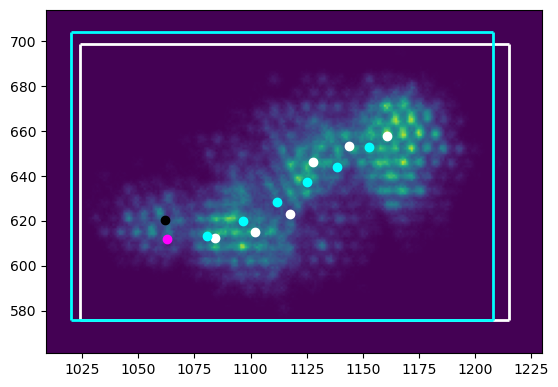

In [24]:
plot_output(11)

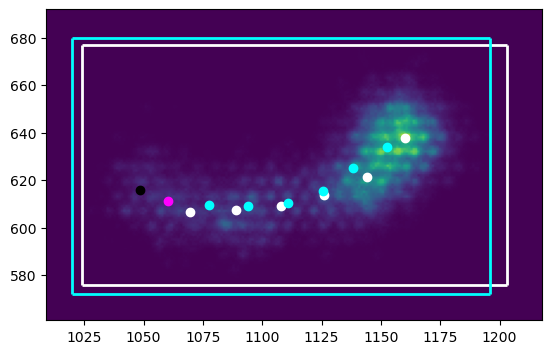

In [25]:
plot_output(9)

# Visually most of the tracks look similar so lets quantify our performance

We'll start with bounding box quantification. We use the IOU which stands for "intersection over union" metric. This metric is the ratio of the areas of the intersection to union of the truth and predicted bounding boxes. Perfect overlap is 1, no overlap is 0

![image info](../figures/IOU_def.png)

In [26]:
def bb_intersection_over_union(xmin1, xmax1, ymin1, ymax1, xmin2, xmax2, ymin2, ymax2):
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(xmin1, xmin2)
    yA = max(ymin1, ymin2)
    xB = min(xmax1, xmax2)
    yB = min(ymax1, ymax2)
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute the area of both the prediction and ground-truth rectangles
    
    boxAArea = (xmax1 - xmin1 + 1) * (ymax1 - ymin1 + 1)
    boxBArea = (xmax2 - xmin2 + 1) * (ymax2 - ymin2 + 1)
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area so we don't double count the intersection
    
    iou = interArea / (boxAArea + boxBArea - interArea)

    return iou

In [27]:
IOUs = []
for i in range(0,len(df)):
    tmp = df.iloc[i]
    tmpyolo = yolo.query('frame == %s'%(i))
    if len(tmpyolo) != 1:
        IOU = -1
    else:
        tmpyolo = tmpyolo.iloc[0]
        IOU = bb_intersection_over_union(tmp['xmin'], tmp['xmax'], tmp['ymin'], tmp['ymax'], 
                                     tmpyolo['xmin'], tmpyolo['xmax'], tmpyolo['ymin'], tmpyolo['ymax'])
    IOUs.append(IOU)

In [28]:
metrics = pd.DataFrame()
metrics['IOU'] = IOUs

(array([          0,           0,           0,           0,           0,           0,           0,           1,          44,          67]),
 array([          0,         0.1,         0.2,         0.3,         0.4,         0.5,         0.6,         0.7,         0.8,         0.9,           1]),
 <BarContainer object of 10 artists>)

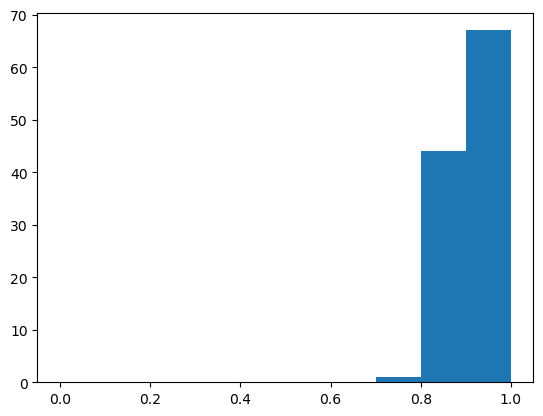

In [29]:
# Let's visualize our IOU scores

plt.hist(metrics['IOU'],range=(0,1))

In [30]:
# Generally speaking our IOUs look great. Lets see what the best and worst overlapping events look like

worstIOUidx = metrics['IOU'].nsmallest(1).index.to_numpy()[0]
bestIOUidx = metrics['IOU'].nlargest(1).index.to_numpy()[0]

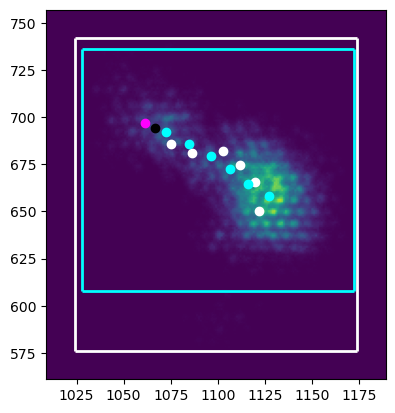

In [33]:
plot_output(worstIOUidx)

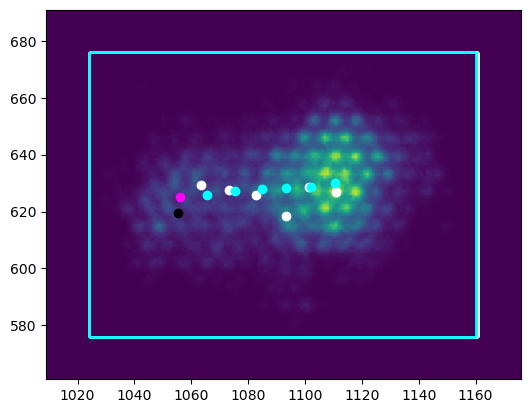

In [34]:
plot_output(bestIOUidx)

# Even the worst IOU overlap looks like a reasonable prediction!
The light below the predicted bounding box in the worst IOU example is very faint. We could improve this if we trained on logarithmic colorscale images

# Next lets assess our keypoint detection performance
Coming up with a good metric to holistically assess keypoint assignments is important, and there's a good deal of flexibilty of how to come up with one. Genreally speaking, with ML metrics, we want something that ranges from 0 to 1 with 0 being maximally bad and 1 being maximally good. The computer vision community often uses a metric called [object keypoint similarity](https://learnopencv.com/object-keypoint-similarity/), which satisfies these criteria. We'll use a simplified version of object keypoint similarity and begin by defining the keypoint similarity of point $i$ as
$$
KS_{i} = \exp\left(\frac{-d_i^2}{2s^2k^2}\right),
$$

where $d_i$ is the Euclidean distance between point the truth and predicted keypoint $i$, $s$ is a scale parameter defined as the area of the truth bounding box, and $k$ is an empirically determined constant. For an image we'll compute the object keypoint similarity, $\rm OKS$, as
$$
\mathrm{OKS}=\frac{1}{N_\mathrm{keypoints}}\sum_{i=1}^{N_\mathrm{keypoints}}KS_i
$$

**Important, OKS is an ordered quantity. The order of the keypoints determined by YOLO is supposed to match the truth ordering. For applications where direction matters, we want OKS to be order dependent. If we don't care about direction, we can reorder the points before computing OKS in such a way that it minimizes the Euclidean distance.**

In [35]:
'''Define a function for order-dependents OKS between truth and measured'''
def order_dependent_OKS(truth,meas,k): #arguments are two tracks which we can think of as rows of dataframes
    distances = []
    for i in range(0,pointsPerTrack): #Loop through each point in the event
        d = np.sqrt((meas['p%sx'%(i)]-truth['p%sx'%(i)])**2+(meas['p%sy'%(i)]-truth['p%sy'%(i)])**2)
        distances.append(d)
    scale = truth['width']*truth['height'] #This is s, we'll compute truth bounding box relative to image size for this
    OKS = np.exp(-1*(np.array(distances)**2)/(2*scale**2*k**2)).sum()/pointsPerTrack
    print(OKS)
    return OKS

In [36]:
'''Compute OKS'''
OKSs = []
for i in range(0,len(df)):
    tmp = df.iloc[i]
    tmpyolo = yolo.query('frame == %s'%(i))
    if len(tmpyolo) != 1:
        OKS = -1
    else:
        tmpyolo = tmpyolo.iloc[0]
        OKS = order_dependent_OKS(tmp,tmpyolo,k=0.001)
    OKSs.append(OKS)

0.9377350319609986
0.8600912259762209
0.8800420692586313
0.9184460657442275
0.7925739379172752
0.9668452810535177
0.9138412147163921
0.8481298801908178
0.8884256824717852
0.9199719711495987
0.896525617050082
0.9378472464038303
0.7727979165858355
0.9130986515690583
0.9610094018542753
0.936752940367307
0.7396703927992067
0.9773231633933124
0.8857094761810193
0.5080041621829603
0.8854767846256968
0.8129147530412008
0.9756836440904749
0.9652509585718032
0.9570330504575313
0.9725932261137468
0.9073840395788804
0.9144102731674115
0.9729315033595155
0.910582757895242
0.4547865350587142
0.8333987192526219
0.8527676134445311
0.9394979674514835
0.944992549763734
0.7531602314918727
0.3039790071130927
0.8063542647977407
0.848357060892245
0.9331007424318644
0.9436685069117615
0.9147999843156759
0.7614035060575972
0.6759664784104905
0.9422656418050794
0.8387023705904574
0.9765196204602832
0.8469018841516478
0.9131190016937186
0.8757344078277567
0.8961612438966027
0.979212789464181
0.9015299995103513

In [37]:
'''Add OKS to the metrics dataframe'''
metrics['OKS'] = OKSs

(array([          0,           0,           0,           1,           1,           1,           3,           7,          34,          65]),
 array([          0,         0.1,         0.2,         0.3,         0.4,         0.5,         0.6,         0.7,         0.8,         0.9,           1]),
 <BarContainer object of 10 artists>)

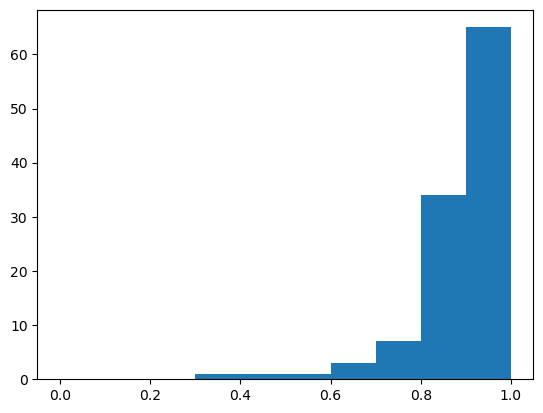

In [38]:
plt.hist(metrics['OKS'],range=(0,1))

(array([          1,           0,           1,           1,           1,           2,           5,          11,          38,          52]),
 array([    0.30398,     0.37186,     0.43974,     0.50762,      0.5755,     0.64338,     0.71125,     0.77913,     0.84701,     0.91489,     0.98277]),
 <BarContainer object of 10 artists>)

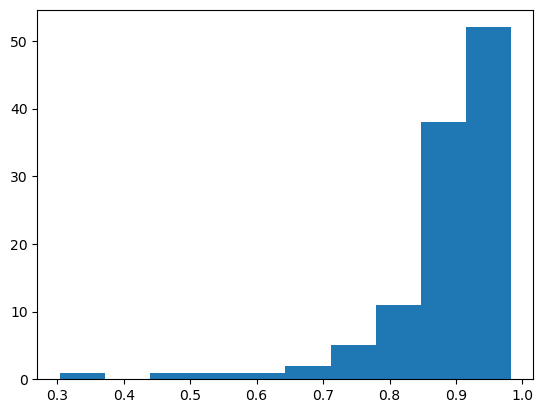

In [39]:
plt.hist(metrics['OKS'])

In [40]:
metrics.query('OKS > 0')['OKS'].mean()

0.8871067698758442

In [41]:
# Let's see what the best and worst keypoint images look like

worstOKSidx = metrics.query('OKS > 0')['OKS'].nsmallest(1).index.to_numpy()[0]
avgOKSidxs = metrics.query('0.8 > OKS > 0.75')['OKS'].nsmallest(10).index.to_numpy()
bestOKSidx = metrics['OKS'].nlargest(1).index.to_numpy()[0]

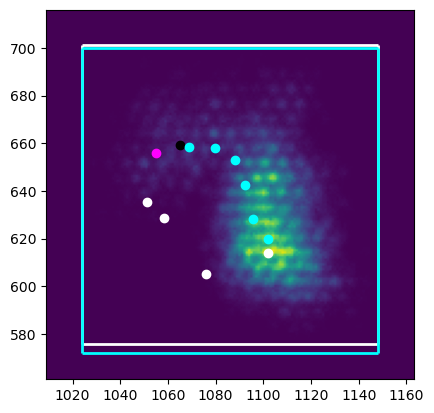

In [42]:
'''Looks like there's a problem with the truth version here, not YOLO's prediction!'''
plot_output(worstOKSidx)

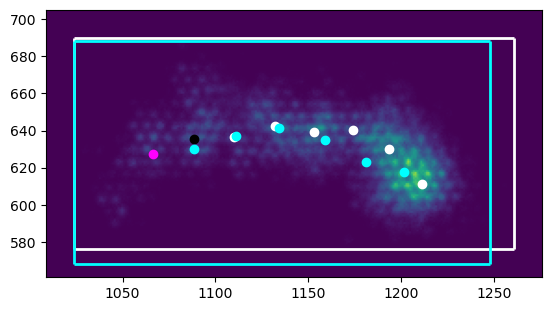

In [43]:
plot_output(avgOKSidxs[3])

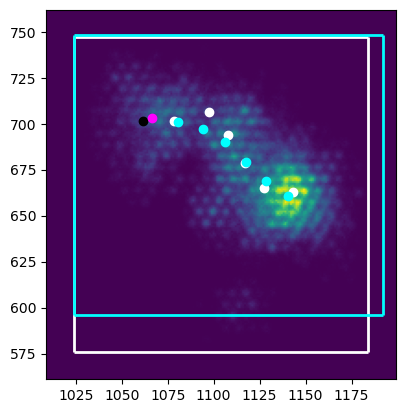

In [44]:
plot_output(bestOKSidx)

# A few other things we can do:
1. Compute a head/tail OKS score only considering head and tail points. Then you can compare the OKS with the order YOLO gave versus the reverse order. This would be more interesting in a more diverse set where we get head/tail wrong sometimes
2. Assess how good the heads and tails individually were assessed
3. Repeat these notebooks with more realistic simulation that includes Noise
4. Repeat this for images with multiple tracks
5. Play around with estimating track angles based on keypoint trajectories and comparing to truth